In [1]:
from scipy import io
from scipy.signal import butter, lfilter
import h5py
import random
import numpy as np
import os

In [27]:
from bot_slackclient import send_slack_message
send_slack_message("test (startup)")

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

### Load data

In [4]:
ecog_matfile = io.loadmat('test_ecog_data.mat')
raw_data = ecog_matfile['raw_data']
raw_acc = ecog_matfile['raw_acc']
mv_acc = ecog_matfile['mv_acc']

In [5]:
chan_names = ecog_matfile['chan_names']

In [6]:
chan_names = chan_names[0]
chan_names = chan_names.tolist()
for i in range(len(chan_names)):
  chan_names[i] = chan_names[i][0]

In [7]:
chan_names

[u'P3_1_d',
 u'P3_2_d',
 u'F3_1_d',
 u'F3_2_d',
 u'C3_1_d',
 u'C3_2_d',
 u'C3_3_d',
 u'C3_4_d',
 u'T5_1_d',
 u'T5_2_d',
 u'T5_3_d',
 u'T5_4_d']

In [8]:
raw_data.shape

(12, 136001)

In [9]:
mv_acc.shape

(1, 136001)

In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
mmsc = MinMaxScaler(feature_range=(0, 1))                            
raw_data = mmsc.fit_transform(raw_data.T).T
mv_acc = mmsc.fit_transform(mv_acc.T).T
raw_acc = mmsc.fit_transform(raw_acc.T).T

In [11]:
len_raw_data = raw_data.shape[1]

In [12]:
raw_data_train = raw_data[4:8,0:(len_raw_data//2)]
raw_data_val = raw_data[4:8,(len_raw_data//2):(2*len_raw_data//3)]
raw_data_test = raw_data[4:8,(2*len_raw_data//3):]

mv_acc_train = mv_acc[:,0:(len_raw_data//2)]
mv_acc_val = mv_acc[:,(len_raw_data//2):(2*len_raw_data//3)]
mv_acc_test = mv_acc[:,(2*len_raw_data//3):]

In [13]:
#mv_acc_train = raw_acc[:,0:(len_raw_data//2)]
#mv_acc_val = raw_acc[:,(len_raw_data//2):(2*len_raw_data//3)]
#mv_acc_test = raw_acc[:,(2*len_raw_data//3):]

In [14]:
print(raw_data_train.shape)
print(raw_data_val.shape)
print(raw_data_test.shape)
print(mv_acc_train.shape)
print(mv_acc_val.shape)
print(mv_acc_test.shape)

(4, 68000)
(4, 22667)
(4, 45334)
(1, 68000)
(1, 22667)
(1, 45334)


In [15]:
mv_acc[0,::10].shape

(13601,)

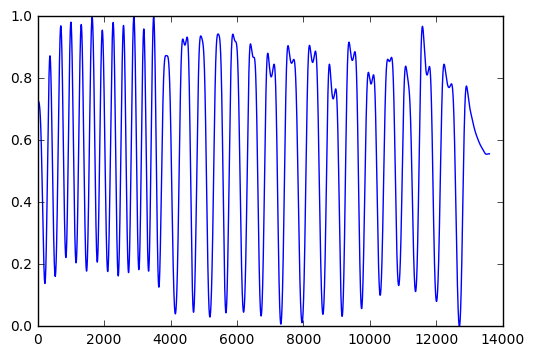

In [16]:
plt.plot(mv_acc[0,::10])

### Functions for data generation (to fit with fit_generator)

In [17]:
def generate_slice(slice_len, val=False):
    if val:
        X = raw_data_val
        y = mv_acc_val
    else:
        X = raw_data_train
        y = mv_acc_train
    
    len_X = X.shape[1]
    
    while True:
        slice_start = np.random.choice(len_X - slice_len)
        slice_end = slice_start + slice_len
        slice_x = X[:,slice_start:slice_end].T
        slice_y = y[0,slice_end]

        return slice_x, slice_y

In [18]:
def data_generator(batch_size, slice_len, val=False):
    while True:
        batch_x = []
        batch_y = []
        
        for i in range(0, batch_size):
            x, y = generate_slice(slice_len, val=val)
            batch_x.append(x)
            batch_y.append(y)
            
        y = np.array(batch_y)
        x = np.array([i for i in batch_x])
        yield (x, y)

### Training neural network

In [280]:
from keras.layers import Convolution1D, Dense, Dropout, Input, merge, GlobalMaxPooling1D, MaxPooling1D, Flatten, LSTM
from keras.models import Model, load_model
from keras.optimizers import RMSprop

#### Params

In [279]:
slice_len = 500

nb_filters = 10
kernel_size = 50

conv1d_act = "relu"

dense1_n = 20
dense1_act = "relu"

dense2_n = 20
dense2_act = "relu"

do = 0

path_to_save_model = 'testmodel2'

#### Architecture

In [281]:
input_seq = Input(shape=(slice_len, 4))
convolved = Convolution1D(nb_filters, kernel_size, border_mode="same", activation=conv1d_act)(input_seq)
pooled = GlobalMaxPooling1D()(convolved)
dense1 = Dense(dense1_n, activation=dense1_act)(pooled)
dense1do = Dropout(do)(dense1)
dense2 = Dense(dense2_n, activation=dense2_act)(dense1do)
dense2do = Dropout(do)(dense2)

out = Dense(1, activation='linear')(dense2do)

model = Model(input=input_seq, output=out)

model.compile(loss="mse", optimizer="adam", metrics=["mse"])

from keras.callbacks import EarlyStopping, ModelCheckpoint

#nb_epoch = 100000


/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(10, 50, padding="same", activation="relu")`
  from ipykernel import kernelapp as app
/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


#### Early stopping

In [282]:
samples_per_epoch = 1000
nb_epoch = 200
patience = 10

earlyStopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(path_to_save_model, monitor='val_loss', verbose=1,
                               save_best_only=True, mode='auto', period=1)

#### Fit

In [283]:
history = model.fit_generator(data_generator(slice_len=slice_len, batch_size=32), samples_per_epoch, nb_epoch, 
                    callbacks=[earlyStopping, checkpointer], verbose=1, nb_val_samples=1000, 
                    validation_data=data_generator(slice_len=slice_len, batch_size=32, val=True))

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., 1000, 200, callbacks=[<keras.ca..., validation_data=<generator..., verbose=1, validation_steps=1000)`
  app.launch_new_instance()


Epoch 1/200
1000/1000 [==============================] - 10s - loss: 0.0368 - mean_squared_error: 0.0368 - val_loss: 0.0525 - val_mean_squared_error: 0.0525
Epoch 2/200
1000/1000 [==============================] - 10s - loss: 0.0330 - mean_squared_error: 0.0330 - val_loss: 0.0470 - val_mean_squared_error: 0.0470
Epoch 3/200
1000/1000 [==============================] - 10s - loss: 0.0320 - mean_squared_error: 0.0320 - val_loss: 0.0389 - val_mean_squared_error: 0.0389
Epoch 4/200
1000/1000 [==============================] - 10s - loss: 0.0313 - mean_squared_error: 0.0313 - val_loss: 0.0411 - val_mean_squared_error: 0.0411
Epoch 5/200
1000/1000 [==============================] - 10s - loss: 0.0307 - mean_squared_error: 0.0307 - val_loss: 0.0413 - val_mean_squared_error: 0.0413
Epoch 6/200
1000/1000 [==============================] - 10s - loss: 0.0303 - mean_squared_error: 0.0303 - val_loss: 0.0533 - val_mean_squared_error: 0.0533
Epoch 7/200
1000/1000 [==============================] - 1

KeyboardInterrupt: 

['mean_squared_error', 'loss', 'val_mean_squared_error', 'val_loss']


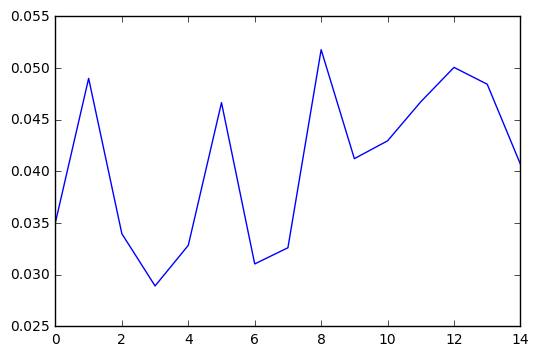

In [285]:
import matplotlib.pyplot as plt
%matplotlib inline

print(history.history.keys())

plt.plot(history.history['val_loss'])


### Testing

In [287]:
model = load_model('testmodel2')

In [290]:
len_test = raw_data_test.shape[1]
idxs = np.arange(0,len_test - slice_len,10)

txs_0 = np.zeros([idxs.shape[0],slice_len,4])
tys_0 = np.zeros([idxs.shape[0],1])

In [291]:
k = 0

for i in np.arange(0,len_test - slice_len,10):
    slice_start = i
    slice_end = slice_start + slice_len
    slice_x = raw_data_test[:,slice_start:slice_end].T
    slice_y = mv_acc_test[0,slice_end]
    
    txs_0[k] = slice_x
    tys_0[k] = slice_y
    
    k = k+1

In [ ]:
tys_pred = model.predict(txs_0)

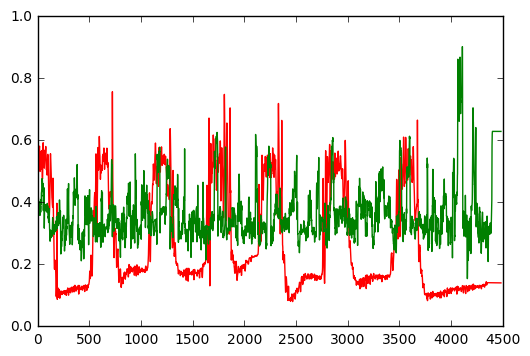

In [297]:
plt.plot(tys_0,'r')
plt.plot(tys_pred,'g')
plt.show()

# Cycle to iterate over parameter values

#### Prepare the network

In [28]:
from keras.layers import Conv1D, Dense, Dropout, Input, merge, GlobalMaxPooling1D, MaxPooling1D, Flatten, LSTM
from keras.models import Model, load_model
from keras.optimizers import RMSprop

from keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
slice_len = 500

nb_filters = 10
kernel_size = 50

conv1d_act = "relu"

dense1_n = 20
dense1_act = "relu"

dense2_n = 20
dense2_act = "relu"

do = 0


samples_per_epoch = 100
nb_val_samples = 50

nb_epoch = 200
patience = 10

batch_size = 32

#### Prepare testing data

In [30]:
len_test = raw_data_test.shape[1]
idxs = np.arange(0,len_test - slice_len,10)

txs_0 = np.zeros([idxs.shape[0],slice_len,4])
tys_0 = np.zeros([idxs.shape[0],1])

k = 0

for i in np.arange(0,len_test - slice_len,10):
    slice_start = i
    slice_end = slice_start + slice_len
    slice_x = raw_data_test[:,slice_start:slice_end].T
    slice_y = mv_acc_test[0,slice_end]
    
    txs_0[k] = slice_x
    tys_0[k] = slice_y
    
    k = k+1

#### Choose the variable to iterate over here:

In [31]:
## var_name = [ k for k,v in locals().iteritems() if v is var][0] ## sample

In [32]:
var_name = 'kernel_size'

#### Set directory to save best models and figures

In [33]:
dirname = var_name

if not os.path.exists(dirname):
    os.makedirs(dirname)

In [34]:
dirname

'kernel_size'

In [ ]:
for kernel_size in np.arange(10,250,10):
    
    # path to save model
    path_to_save_model_par = dirname+'/'+'savedmodel'+'_'+str(kernel_size)
    figure_name = path_to_save_model_par
    
    # build the network
    input_seq = Input(shape=(slice_len, 4))
    convolved = Conv1D(nb_filters, kernel_size, padding="same", activation=conv1d_act)(input_seq)
    # Update your `Conv1D` call to the Keras 2 API: `Conv1D(10, 20, padding="same", activation="relu")`
    pooled = GlobalMaxPooling1D()(convolved)
    dense1 = Dense(dense1_n, activation=dense1_act)(pooled)
    dense1do = Dropout(do)(dense1)
    dense2 = Dense(dense2_n, activation=dense2_act)(dense1do)
    dense2do = Dropout(do)(dense2)
    out = Dense(1, activation='linear')(dense2do)
    model = Model(input=input_seq, output=out)
    model.compile(loss="mse", optimizer="adam", metrics=["mse"])
    
    # early stopping
    earlyStopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(path_to_save_model_par, monitor='val_loss', verbose=1,
                               save_best_only=True, mode='auto', period=1)

    # fit model
    history = model.fit_generator(data_generator(slice_len=slice_len, batch_size=batch_size), samples_per_epoch, nb_epoch, 
                    callbacks=[earlyStopping, checkpointer], verbose=1, nb_val_samples=nb_val_samples, 
                    validation_data=data_generator(slice_len=slice_len, batch_size=batch_size, val=True))

    # plot progress
    plt.clf()
    plt.plot(history.history['val_loss'])
    plt.savefig(figure_name+'prog')
    
    
    # test the best model
    
    model = load_model(path_to_save_model_par)
    
    tys_pred = model.predict(txs_0)
    
    plt.clf()
    plt.plot(tys_0,'g')
    plt.plot(tys_pred,'b')
    plt.savefig(figure_name+'pred')

send_slack_message("CALCULATIONS FINISHED")


/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., 100, 200, callbacks=[<keras.ca..., validation_data=<generator..., verbose=1, validation_steps=50)`


Epoch 1/200
100/100 [==============================] - 4s - loss: 0.1340 - mean_squared_error: 0.1340 - val_loss: 0.0961 - val_mean_squared_error: 0.0961
Epoch 2/200
100/100 [==============================] - 0s - loss: 0.0933 - mean_squared_error: 0.0933 - val_loss: 0.0924 - val_mean_squared_error: 0.0924
Epoch 3/200
100/100 [==============================] - 0s - loss: 0.0892 - mean_squared_error: 0.0892 - val_loss: 0.0899 - val_mean_squared_error: 0.0899
Epoch 4/200
100/100 [==============================] - 0s - loss: 0.0912 - mean_squared_error: 0.0912 - val_loss: 0.0935 - val_mean_squared_error: 0.0935
Epoch 5/200
100/100 [==============================] - 0s - loss: 0.0870 - mean_squared_error: 0.0870 - val_loss: 0.0877 - val_mean_squared_error: 0.0877
Epoch 6/200
100/100 [==============================] - 0s - loss: 0.0855 - mean_squared_error: 0.0855 - val_loss: 0.0885 - val_mean_squared_error: 0.0885
Epoch 7/200
100/100 [==============================] - 0s - loss: 0.0830 - m